# Fine-tuning and deploying ProtBert Model for Protein Classification using Amazon SageMaker


## Contents
1. [Motivation](#Motivation)
2. [What is ProtBert?](#What-is-ProtBert?)
3. [Notebook Overview](#Notebook-Overview)
    - [Setup](#Setup)
4. [Dataset](#Dataset)
    - [Download Data](#Download-Data)
5. [Data Exploration](#Data-Exploration)
    - [Upload Data to S3](#Upload-Data-to-S3)
6. [Training script](#Training-script)
7. [Train on Amazon SageMaker](#Train-on-Amazon-SageMaker)
8. [Deploy the Model on Amazon SageMaker](#Deploy-the-model-on-Amazon-SageMaker)
    - [Create a model object](#Create-a-model-object)
    - [Deploy the model on an endpoint](#Deploy-the-model-on-an-endpoint)
9. [Predicting SubCellular Localization of Protein Sequences](#Predicting-SubCellular-Localization-of-Protein-Sequences)
10. [References](#References)
---

## Motivation
<img src="https://upload.wikimedia.org/wikipedia/commons/6/60/Myoglobin.png"
     alt="Protein Sequence"
     style="float: left;"
     height = 100
     width = 250/>
**Proteins** are the key fundamental macromolecules governing in biological bodies. The study of protein localization is important to comprehend the function of protein and has great importance for drug design and other applications. It also plays an important role in characterizing the cellular function of hypothetical and newly discovered proteins [1]. There are several research endeavours that aim to localize whole proteomes by using high-throughput approaches [2–4]. These large datasets provide important information about protein function, and more generally global cellular processes. However, they currently do not achieve 100% coverage of proteomes, and the methodology used can in some cases cause mislocalization of subsets of proteins [5,6]. Therefore, complementary methods are necessary to address these problems. In this notebook, we will leverage Natural Language Processing (NLP) techniques for protein sequence classification. The idea is to interpret protein sequences as sentences and their constituent – amino acids –
as single words [7]. More specifically we will fine tune Pytorch ProtBert model from Hugging Face library.

## What is ProtBert?

ProtBert is a pretrained model on protein sequences using a masked language modeling (MLM) objective. It is based on Bert model which is pretrained on a large corpus of protein sequences in a self-supervised fashion. This means it was pretrained on the raw protein sequences only, with no humans labelling them in any way (which is why it can use lots of publicly available data) with an automatic process to generate inputs and labels from those protein sequences [8]. For more information about ProtBert, see [`ProtTrans: Towards Cracking the Language of Life’s Code Through Self-Supervised Deep Learning and High Performance Computing`](https://www.biorxiv.org/content/10.1101/2020.07.12.199554v2.full).

---


Next let us import the common libraries needed for the operations done later.

In [1]:
import re
import json
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import numpy as np
import pandas as pd

import torch
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [2]:
from transformers import BertTokenizer

Next, let's verify the version, create a SageMaker session and get the execution role which is the IAM role arn used to give training and hosting access to your data.

As the last step of setting up the enviroment lets set a value to a random seed so that we can reproduce the same results later.

In [3]:
RANDOM_SEED = 43
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

---

## Dataset

We are going to use a opensource public dataset of protein sequences available [here](http://www.cbs.dtu.dk/services/DeepLoc-1.0/data.php). The dataset is a `fasta file` composed by header and protein sequence. The header is composed by the accession number from Uniprot, the annotated subcellular localization and possibly a description field indicating if the protein was part of the test set. The subcellular localization includes an additional label, where S indicates soluble, M membrane and U unknown[9].
Sample of the data is as follows :

```
>Q9SMX3 Mitochondrion-M test
MVKGPGLYTEIGKKARDLLYRDYQGDQKFSVTTYSSTGVAITTTGTNKGSLFLGDVATQVKNNNFTADVKVST
DSSLLTTLTFDEPAPGLKVIVQAKLPDHKSGKAEVQYFHDYAGISTSVGFTATPIVNFSGVVGTNGLSLGTDV
AYNTESGNFKHFNAGFNFTKDDLTASLILNDKGEKLNASYYQIVSPSTVVGAEISHNFTTKENAITVGTQHAL>
DPLTTVKARVNNAGVANALIQHEWRPKSFFTVSGEVDSKAIDKSAKVGIALALKP"
```

A sequence in FASTA format begins with a single-line description, followed by lines of sequence data. The definition line (defline) is distinguished from the sequence data by a greater-than (>) symbol at the beginning. The word following the ">" symbol is the identifier of the sequence, and the rest of the line is the description.

### Download Data

Since the data is in fasta format, we can leverage `Bio.SeqIO.FastaIO` library to read the dataset. Let us install the Bio package.

In [4]:
!pip install Bio -q
import Bio

Using the Bio package we will read the data directly by filtering out the columns that are of interest. We will also add a space seperater between each character in the sequence field which will be useful during model training.

In [5]:
data = pd.read_csv('../input/proteinlocationpredictionchallenge/train.csv')
data.head(2)

,ID,sequence,Kingdom,seq_len,Nucleus,Cytoplasm,Membrane,Cell membrane,Extracellular
0,train_0,MAAAAAAAAAAGAAGGRGSGPGRRRHLVPGAGGEAGEGAPGGAGDY...,Metazoa,306,1.0,1.0,0.0,0.0,0.0
1,train_1,MAAAAAAAAALGVRLRDCCSRGAVLLLFFSLSPRPPAAAAWLLGLR...,Metazoa,951,0.0,0.0,1.0,1.0,0.0


### Data Exploration
Dataset consists of 14K sequences and 6 columns in total. We will only use the following columns during training:

* _**id**_ : Unique identifier given each sequence in the dataset.
* _**sequence**_ : Protein sequence. Each character is seperated by a "space". Will be useful for BERT tokernizer.
* _**sequence_length**_ : Character length of each protein sequence. 
* _**location**_ : Classification given each sequence.
* _**is_train**_ : Indicates whether the record be used for training or test. Will be used to seperate the dataset for traning and validation.


First, let's verify if there are any missing values in the dataset.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18206 entries, 0 to 18205
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             18206 non-null  object 
 1   sequence       18206 non-null  object 
 2   Kingdom        18206 non-null  object 
 3   seq_len        18206 non-null  int64  
 4   Nucleus        18206 non-null  float64
 5   Cytoplasm      18206 non-null  float64
 6   Membrane       18206 non-null  float64
 7   Cell membrane  18206 non-null  float64
 8   Extracellular  18206 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [7]:
data.isnull().values.any()

False

As you can see, there are **no** missing values in this dataset. 

Second, we will see the number of available classes (subcellular localization), which will be used for protein classification. 

In [8]:
unique_classes = data.Kingdom.unique()
print("Number of classes: ", len(unique_classes))
unique_classes

Number of classes:  4


array(['Metazoa', 'Viridiplantae', 'Fungi', 'Other'], dtype=object)

We can see that there are 10 unique classes in the dataset.

Third, lets check the sequence length.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


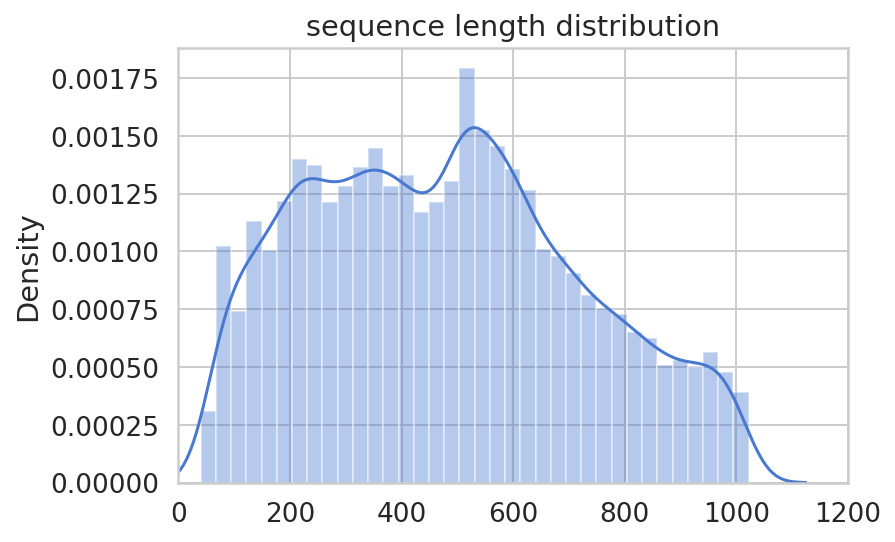

In [9]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
ax = sns.distplot(data['seq_len'].values)
ax.set_xlim(0, 1200)
plt.title(f'sequence length distribution')
plt.grid(True)

This is an important observation as PROTBERT model receives a fixed length of sentence as input. Usually the maximum length of a sentence depends on the data we are working on. For sentences that are shorter than this maximum length, we will have to add paddings (empty tokens) to the sentences to make up the length.

As you can see from the above plot that most of the sequences lie under the length of around 1500, therefore, its a good idea to select the `max_length = 1536` but that will increase the training time for this sample notebook, therefore, we will use `max_length = 512`. You can experiment it with the bigger length and it does improves the accuracy as most of the subcellular localization information of protiens is stored at the end of the sequence. 

Next let's factorize the protein classes. 

In [10]:
data.columns

Index(['ID', 'sequence', 'Kingdom', 'seq_len', 'Nucleus', 'Cytoplasm',
       'Membrane', 'Cell membrane', 'Extracellular'],
      dtype='object')

In [11]:
categories = data.Kingdom.astype('category').cat
data['Kingdom'] = categories.codes
class_names = categories.categories
print(class_names)

Index(['Fungi', 'Metazoa', 'Other', 'Viridiplantae'], dtype='object')


In [12]:
data.head(2)

,ID,sequence,Kingdom,seq_len,Nucleus,Cytoplasm,Membrane,Cell membrane,Extracellular
0,train_0,MAAAAAAAAAAGAAGGRGSGPGRRRHLVPGAGGEAGEGAPGGAGDY...,1,306,1.0,1.0,0.0,0.0,0.0
1,train_1,MAAAAAAAAALGVRLRDCCSRGAVLLLFFSLSPRPPAAAAWLLGLR...,1,951,0.0,0.0,1.0,1.0,0.0


In [13]:
data.shape

(18206, 9)

In [14]:
s = data['sequence'][5]
s = " ".join(s)
print(s)

M A A A A A A K I A P S M L S S D F A N L A A E A D R M V R L G A D W L H M D I M D G H F V P N L T I G A P V I Q S L R K H T K A Y L D C H L M V T N P S D Y V E P L A K A G A S G F T F H I E V S R D N W Q E L I Q S I K A K G M R P G V S L R P G T P V E E V F P L V E A E N P V E L V L V M T V E P G F G G Q K F M P E M M E K V R A L R K K Y P S L D I E V D G G L G P S T I D V A A S A G A N C I V A G S S I F G A A E P G E V I S A L R K S V E G S Q N K S


In [15]:
max_len = data.seq_len.max() # this is the max length of the sequence
max_len

1022

In [16]:
max_len = 512

Next, let's devide the dataset into training and test. We can leverage the `is_train` column to do the split. 

In [17]:
PRE_TRAINED_MODEL_NAME = 'Rostlab/prot_bert_bfd_localization'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=False)

Downloading:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/210 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

In [18]:
import torch.distributed as dist

In [19]:
import torch
from torch import nn
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import Dataset, DataLoader, RandomSampler, TensorDataset

class ProteinSequenceDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.protein_set = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.protein_set)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        targets = self.protein_set.iloc[idx, -5:]
        targets = np.array([targets])
        targets = targets.astype('float').reshape(-1, 5)
                
        """inputs = self.protein_set.iloc[idx, 2:4]
        inputs = np.array([inputs])
        inputs = inputs.astype('float').reshape(-1, 2)"""
        
        sequence = str(self.protein_set.sequence[idx])
      
        encoding = self.tokenizer.encode_plus(
            sequence,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        sample = {
          'protein_sequence': sequence,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          #'inputs': inputs,
          'targets': targets
        }

        return sample 

In [20]:
# dist.init_process_group(
#   backend='nccl',
#   world_size=1,
#   rank=0
# )
# dist.all_gather(output, gather_objects[dist.get_rank()])
# print(output)

In [21]:
def get_train_data_loader(batch_size=4, training_dir= "../input/proteinlocationpredictionchallenge/train.csv"):
    dataset = pd.read_csv(training_dir)[-6000:].reset_index(drop=True)
    categories = dataset.Kingdom.astype('category').cat
    dataset['Kingdom'] = categories.codes
    
    dataset['sequence'] = dataset['sequence'].map(lambda s: " ".join(s)).values
    
    train_data = ProteinSequenceDataset(
        dataset,
        tokenizer=tokenizer,
        max_len=max_len
  )
    """train_sampler = torch.utils.data.distributed.DistributedSampler(
            dataset,
            num_replicas=dist.get_world_size(),
            rank=dist.get_rank()
            )"""
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True,
                                 sampler=train_sampler)
    return train_dataloader

def get_test_data_loader(batch_size=4, testing_dir= "../input/proteinlocationpredictionchallenge/test.csv"):
    test_dataset = pd.read_csv(testing_dir)
    categories = test_dataset.Kingdom.astype('category').cat
    test_dataset['Kingdom'] = categories.codes
    
    test_dataset['sequence'] = test_dataset['sequence'].map(lambda s: " ".join(s)).values
    
    test_dataset[['Nucleus', 'Cytoplasm', 'Membrane', 'Cell membrane', 'Extracellular']] = 0
    
    test_data = ProteinSequenceDataset(test_dataset,
        tokenizer=tokenizer,
        max_len=max_len
  )
    test_sampler = RandomSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    return test_dataloader

In [22]:
def get_valid_data_loader(batch_size=4, training_dir= "../input/proteinlocationpredictionchallenge/train.csv"):
    dataset = pd.read_csv(training_dir)[2000:2500].reset_index(drop=True)
    categories = dataset.Kingdom.astype('category').cat
    dataset['Kingdom'] = categories.codes
    
    dataset['sequence'] = dataset['sequence'].map(lambda s: " ".join(s)).values
    
    train_data = ProteinSequenceDataset(
        dataset,
        tokenizer=tokenizer,
        max_len=max_len
  )
    """train_sampler = torch.utils.data.distributed.DistributedSampler(
            dataset,
            num_replicas=dist.get_world_size(),
            rank=dist.get_rank()
            )"""
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True,
                                 sampler=train_sampler)
    return train_dataloader

In [23]:
for data in get_test_data_loader(3):
    #print(data['protein_sequence'], '\n')
    print(data['input_ids'])
    print(data['input_ids'][0].sum(), data['input_ids'][1].sum(), data['input_ids'][2].sum())
    break

tensor([[ 2, 21,  5,  ...,  0,  0,  0],
        [ 2, 21, 16,  ...,  0,  0,  0],
        [ 2, 21,  5,  ...,  0,  0,  0]])
tensor(5428) tensor(4944) tensor(2291)


In [24]:
!pip install torch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 153.9 kB/s eta 0:00:00a 0:00:01


In [25]:
import torch_optimizer as optim

In [26]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn.functional as F
import torch.nn as nn

PRE_TRAINED_MODEL_NAME = 'Rostlab/prot_bert_bfd_localization'
class ProteinClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ProteinClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.classifier = nn.Sequential(nn.Dropout(p=0.35),
                                        nn.Linear(self.bert.config.hidden_size, num_classes),
                                        nn.Sigmoid())
        
    def forward(self, input_ids, attention_mask):
        output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        return self.classifier(output.pooler_output)

def model_fn(model_dir):
   
    print('Loading the trained model...')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ProteinClassifier(5) # pass number of classes, in our case its num_classes=5
    with open(os.path.join(model_dir, 'model.pth'), 'rb') as f:
        model.load_state_dict(torch.load(f, map_location=device))
    return model.to(device)

def input_fn(request_body, request_content_type):
    """An input_fn that loads a pickled tensor"""
    if request_content_type == "application/json":
        sequence = json.loads(request_body)
        print("Input protein sequence: ", sequence)
        encoded_sequence = tokenizer.encode_plus(
        sequence, 
        max_length = max_len, 
        add_special_tokens = True, 
        return_token_type_ids = False, 
        padding = 'max_length', 
        return_attention_mask = True, 
        return_tensors='pt'
        )
        input_ids = encoded_sequence['input_ids']
        attention_mask = encoded_sequence['attention_mask']

        return input_ids, attention_mask

    raise ValueError("Unsupported content type: {}".format(request_content_type))


def predict_fn(input_data, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    input_id, input_mask = input_data
    input_id = input_id.to(device)
    input_mask = input_mask.to(device)
    with torch.no_grad():
        output = model(input_id, input_mask)
        _, prediction = torch.max(output, dim=1)
        return prediction

In [27]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()

In [28]:
num_classes=5 # num_classes = len(['Nucleus', 'Cytoplasm', 'Membrane', 'Cell membrane', 'Extracellular'])

In [29]:
model = ProteinClassifier(num_classes).to(device)
#model.eval()

Downloading:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_bert_bfd_localization were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
epochs = 5
model_dir2 = './'

In [31]:
def freeze(model, frozen_layers):
    modules = [model.bert.encoder.layer[:frozen_layers]] 
   
    for module in modules:
        for param in module.parameters():
            param.requires_grad = False
            
def train():
    
    world_size = 1#dist.get_world_size()
    rank = 0#dist.get_rank()
    local_rank = 0#dist.get_local_rank()
    
    train_loader = get_train_data_loader(batch_size=4)
    """if rank == 0:
        test_loader = get_test_data_loader(batch_size=1)
        print("Max length of sequence: ",  max_len)
        #print("Freezing {} layers".format(frozen_layers=10))
        print("Model used: ", PRE_TRAINED_MODEL_NAME)"""

    model = ProteinClassifier(
        num_classes  # The number of output labels.
    )
    freeze(model, frozen_layers=0)
    ##### model = DDP(model.to(device), broadcast_buffers=False)
    torch.cuda.set_device(local_rank)
    model.cuda(local_rank)
    
    optimizer = optim.Lamb(
            model.parameters(), 
            lr = 0.3e-4,# * dist.get_world_size(), 
            betas=(0.9, 0.999), 
            eps=1e-8, 
            weight_decay=0.01)
    
    total_steps = len(train_loader.dataset)
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps)
    
    loss_fn = nn.BCEWithLogitsLoss().to(device)
    
    for epoch in range(1, epochs + 1):
        print("epoch", epoch)
        model.train()
        for step, batch in enumerate(train_loader):
            b_input_ids = batch['input_ids'].to(device)
            b_input_mask = batch['attention_mask'].to(device)
            b_labels = batch['targets'].to(device)

            outputs = model(b_input_ids,attention_mask=b_input_mask)
          
            loss = loss_fn(outputs[0], b_labels[0][0])

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()
            optimizer.zero_grad()
            
            """if step % args.log_interval == 0 and rank == 0:
                logger.info(
                    "Collecting data from Master Node: \n Train Epoch: {} [{}/{} ({:.0f}%)] Training Loss: {:.6f}".format(
                        epoch,
                        step * len(batch['input_ids'])*world_size,
                        len(train_loader.dataset),
                        100.0 * step / len(train_loader),
                        loss.item(),
                    )
                )
            if args.verbose :
                print('Batch', step, "from rank", rank)
        if rank == 0:
            test(model, test_loader, device)
            
        valid_loader = get_valid_data_loader(batch_size=1) #SUP
        test(model, valid_loader, device) #SUP
        """
        scheduler.step()
        
    """if rank == 0:
        model_save = model.module if hasattr(model, "module") else model
        save_model(model_save, model_dir2)"""

def save_model(model, model_dir='./'):
    path = os.path.join(model_dir, 'model.pth')
    # recommended way from http://pytorch.org/docs/master/notes/serialization.html
    torch.save(model.state_dict(), path)

def test(model, test_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    loss_fn = nn.BCEWithLogitsLoss().to(device)
    tmp_eval_accuracy, eval_accuracy = 0, 0
    
    with torch.no_grad():
        for batch in test_loader:
            b_input_ids = batch['input_ids'].to(device)
            b_input_mask = batch['attention_mask'].to(device)
            b_labels = batch['targets'].to(device)

            outputs = model(b_input_ids,attention_mask=b_input_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs[0], b_labels[0][0])
            correct_predictions += torch.sum(preds == b_labels)
            losses.append(loss.item())
            
    print('\nTest set: Validation loss: {:.4f}, Validation Accuracy: {:.0f}%\n'.format(
        np.mean(losses),
        (100. * correct_predictions.double() / len(test_loader.dataset)))) / num_classes

In [32]:
train()

Some weights of the model checkpoint at Rostlab/prot_bert_bfd_localization were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch 1
epoch 2
epoch 3
epoch 4
epoch 5


In [33]:
def predict(model, test_loader, device):
    model.eval()
    preds = []  
    
    with torch.no_grad():
        for batch in test_loader:
            b_input_ids = batch['input_ids'].to(device)
            b_input_mask = batch['attention_mask'].to(device)
            
            outputs = model(b_input_ids,attention_mask=b_input_mask).cpu().numpy()
            preds.append(outputs)
            
    return preds

In [34]:
test_loader = get_test_data_loader(batch_size=1)

In [35]:
test_preds = predict(model, test_loader, device)

In [36]:
test_preds_c = test_preds.copy()

In [37]:
# for i, s in enumerate(test_preds_c):
#     test_preds[i] = test_preds[i][0]#.cpu().numpy()[0]
# test_preds

In [38]:
test_dataset = pd.read_csv('../input/proteinlocationpredictionchallenge/test.csv')
test_dataset.head(2)

,ID,sequence,Kingdom,seq_len
0,test_0,MAAAAAAAAAAGAAGGRGSGPGRRRHLVPGAGGEAGEGAPGGAGDY...,Metazoa,306
1,test_1,MAAAAAAAAATNGTGGSSGMEVDAAVVPSVMACGVTGSVSVALHPL...,Metazoa,327


In [39]:
test_dataset.shape, len(test_preds_c)

((6488, 4), 6488)

In [40]:
test_preds_c[20][0]

array([0.50831026, 0.55678684, 0.4960227 , 0.52356684, 0.51233757],
      dtype=float32)

In [41]:
for indx, val in enumerate(['Nucleus', 'Cytoplasm',
       'Membrane', 'Cell membrane', 'Extracellular']):
    for i, s in enumerate(test_preds_c):
        test_preds[i] = test_preds_c[i][0][indx]#.cpu().numpy()[0]
    test_dataset[val] = test_preds

test_dataset

,ID,sequence,Kingdom,seq_len,Nucleus,Cytoplasm,Membrane,Cell membrane,Extracellular
0,test_0,MAAAAAAAAAAGAAGGRGSGPGRRRHLVPGAGGEAGEGAPGGAGDY...,Metazoa,306,0.356789,0.563578,0.446917,0.554209,0.470307
1,test_1,MAAAAAAAAATNGTGGSSGMEVDAAVVPSVMACGVTGSVSVALHPL...,Metazoa,327,0.477330,0.550913,0.555514,0.493213,0.534674
2,test_2,MAAAAAAAGGAALAVSTGLETATLQKLALRRKKVLGAEEMELYELA...,Metazoa,159,0.427831,0.549419,0.511033,0.484764,0.545063
3,test_3,MAAAAAAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNLNK...,Metazoa,358,0.382484,0.543585,0.460757,0.546316,0.481119
4,test_4,MAAAAAETPEVLRECGCKGIRTCLICERQRGSDPPWELPPAKTYRF...,Metazoa,302,0.359767,0.555660,0.451494,0.552895,0.474056
...,...,...,...,...,...,...,...,...,...
6483,test_6483,MYTLYILSLLCAFVTFSECKYPPGPIYPHRPIYPIQPVYPDHCPGV...,Metazoa,138,0.418437,0.549912,0.509230,0.485911,0.548017
6484,test_6484,MYVSNGKDTCQLLGPVSLFVQTLMGMTAVIVLLVKRNYEHPRRKMI...,Fungi,273,0.427106,0.552758,0.510956,0.483646,0.547511
6485,test_6485,MYVWPCAVVLAQYLWFHRRSLPGKAILEIGAGVSLPGILAAKCGAE...,Metazoa,190,0.424720,0.550689,0.510506,0.485007,0.546142
6486,test_6486,MYYHNQHQGKSILSSSRMPISSERHPFLRGNGTGDSGLILSTDAKP...,Viridiplantae,402,0.425972,0.553137,0.510443,0.483600,0.548402


In [42]:
aux_df = pd.DataFrame(columns=['ID', 'target'])
ss = pd.DataFrame(columns=['ID', 'target'])

In [43]:
for indx, val in enumerate(['Nucleus', 'Cytoplasm',
       'Membrane', 'Cell membrane', 'Extracellular']):
    
    aux_df['ID'] = test_dataset['ID'].map(lambda s: "".join([s,"_",val])).values
    aux_df['target'] = test_dataset[val]
    
    ss = pd.concat([ss, aux_df])
ss

,ID,target
0,test_0_Nucleus,0.356789
1,test_1_Nucleus,0.477330
2,test_2_Nucleus,0.427831
3,test_3_Nucleus,0.382484
4,test_4_Nucleus,0.359767
...,...,...
6483,test_6483_Extracellular,0.548017
6484,test_6484_Extracellular,0.547511
6485,test_6485_Extracellular,0.546142
6486,test_6486_Extracellular,0.548402


In [44]:
ss.to_csv("SUBMISSION5.csv", index=False)